In [2]:
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet

--2025-05-09 02:01:03--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 18.155.128.46, 18.155.128.6, 18.155.128.187, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|18.155.128.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47748012 (46M) [application/x-www-form-urlencoded]
Saving to: ‘yellow_tripdata_2023-02.parquet’

yellow_tripdata_202 100%[===================>]  45.54M  6.03MB/s    in 8.3s    

2025-05-09 02:01:12 (5.46 MB/s) - ‘yellow_tripdata_2023-02.parquet’ saved [47748012/47748012]



In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# Set pandas display option to avoid scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
def read_data(file):
    
    df = pd.read_parquet(file, engine = 'fastparquet')
    
    # computing duration
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    # getting standard deviation
    print(df.duration.describe())
    
    # dropping outliers
    df = df[(df.duration >=1) & (df.duration <= 60)]
    
    # cast pickup and dropoff ids into strings - otherwise it'll label-encode them
    df[categorical] = df[categorical].astype(str)
    
    return df

In [4]:
def read_data(file, categorical):
    # Read the data from parquet file
    df = pd.read_parquet(file, engine='fastparquet')
    
    # Ensure datetime columns are in correct format
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
    
    # Compute duration in minutes using vectorized operations
    df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60
    
    # Print the duration statistics
    print(df['duration'].describe())
    
    # Dropping outliers by filtering duration between 1 and 60 minutes
    print(((df.duration >= 1) & (df.duration <= 60)).mean())
    df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]
    
    # Cast categorical columns into strings
    df[categorical] = df[categorical].astype(str)
    
    return df


In [5]:
categorical = ['PULocationID', 'DOLocationID']

df_train = read_data('yellow_tripdata_2023-01.parquet', categorical)
df_val = read_data('yellow_tripdata_2023-02.parquet', categorical)

count   3066766.00
mean         15.67
std          42.59
min         -29.20
25%           7.12
50%          11.52
75%          18.30
max       10029.18
Name: duration, dtype: float64
0.9812202822125979
count   2913955.00
mean         16.02
std          42.84
min         -43.62
25%           7.25
50%          11.80
75%          18.77
max        7053.62
Name: duration, dtype: float64
0.9800944077722545


## One Hot Encoding

In [6]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

# feature matrix
dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts) # feature matrix - training input

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts) # feature matrix - validation input

In [24]:
X_train.shape

(3009173, 516)

In [7]:
target = 'duration'

y_train = df_train[target].values # target values for training data
y_val = df_val[target].values # target values for validation data

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [9]:
y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

13.48793351650686

In [ ]:
sns.distplot(y_train.iloc[:10], label='target')
sns.distplot(y_pred.iloc[:10], label='prediction')

plt.legend()

In [10]:
y_pred_train = lr.predict(X_train)
print('Train RMSE:', mean_squared_error(y_train, y_pred_train, squared=False))
print('Validation RMSE:', mean_squared_error(y_val, y_pred, squared=False))

Train RMSE: 7.649137552443737
Validation RMSE: 13.48793351650686


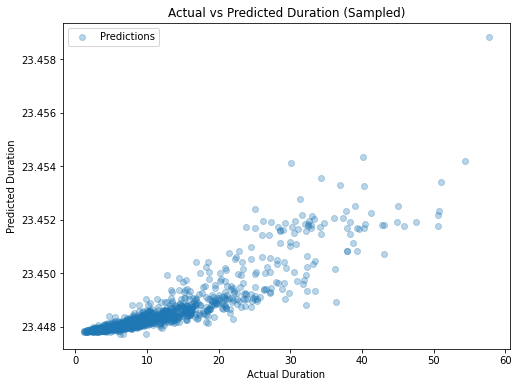

In [15]:
plt.figure(figsize=(8, 6))

# Plot actual vs predicted
plt.scatter(y_val[:1000], y_pred[:1000], alpha=0.3, label='Predictions')

# Add reference line (perfect prediction)
# plt.plot([0, 60], [0, 60], color='red', linestyle='--', label='Ideal Fit')

plt.xlabel('Actual Duration')
plt.ylabel('Predicted Duration')
plt.title('Actual vs Predicted Duration (Sampled)')
plt.legend()
plt.show()

/home/vagrant/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/vagrant/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


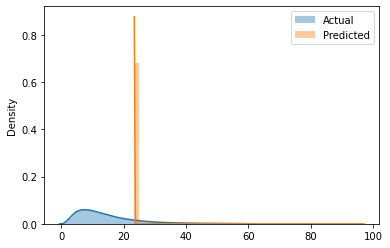

In [23]:
import seaborn as sns

sns.distplot(y_val, label='Actual')
sns.distplot(y_pred, label='Predicted')

plt.legend()

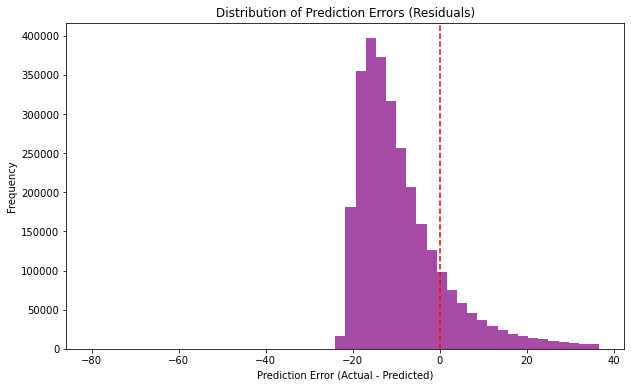

In [19]:
residuals = y_val - y_pred

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, color='purple', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')  # line at 0 error
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors (Residuals)')
plt.show()
